# Parkinson's Disease GNN Analysis Pipeline

This notebook demonstrates a complete Graph Neural Network (GNN)–based analysis pipeline for Parkinson's disease (PD) transcriptomics data using the BioNeuralNet framework.

## Overview

We analyze the GSE165082 dataset, which contains gene expression data from PD patients and healthy controls. The pipeline includes:

1. **Data Loading**: Load and parse PD transcriptomics data
2. **Preprocessing**: Log transformation, HVG selection, normalization
3. **Graph Construction**: Build gene-gene correlation network
4. **Baseline Model**: Train non-graph model for comparison
5. **GNN Training**: Train Graph Convolutional Network (GCN) on gene graph
6. **Embedding Analysis**: Cluster genes and visualize results

## Dataset

- **Source**: GSE165082
- **Samples**: 26 (12 PD, 14 Control)
- **Genes**: 63,677 genes (filtered to top 5,000 HVGs)
- **Platform**: RNA-seq gene expression counts


In [1]:
import sys
from pathlib import Path

# Add project root to path for bioneuralnet imports
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Add PD-Notebooks to path for local processing imports
pd_notebooks = Path().resolve()
if str(pd_notebooks) not in sys.path:
    sys.path.insert(0, str(pd_notebooks))

print(f"Project root added to path: {project_root}")
print(f"PD-Notebooks added to path: {pd_notebooks}")


Project root added to path: C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet
PD-Notebooks added to path: C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet\PD-Notebooks


## Step 1: Data Loading

Load the GSE165082 Parkinson's disease transcriptomics dataset. The loader:
- Parses sample names to extract PD vs Control labels
- Loads gene annotations (symbols, descriptions)
- Returns clean DataFrames ready for analysis


In [2]:
from bioneuralnet.datasets import load_parkinsons_data
# Load PD transcriptomics data (GSE165082)
expression_df, sample_meta, gene_meta = load_parkinsons_data()

print(f"Expression matrix shape: {expression_df.shape} (genes × samples)")
print(f"\nSample condition distribution:")
print(sample_meta['condition'].value_counts())
print(f"\nGene metadata shape: {gene_meta.shape}")
print(f"\nFirst few genes with annotations:")
gene_meta.head()


2025-11-29 15:22:28,869 - bioneuralnet.datasets.parkinsons_loader - INFO - Initialized ParkinsonsLoader with counts='C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet\PD-Notebooks\datasets\GSE165082_PD-CC.counts.txt', annotation='C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet\PD-Notebooks\datasets\Human.GRCh38.p13.annot.tsv'
2025-11-29 15:22:28,870 - bioneuralnet.datasets.parkinsons_loader - INFO - Loading PD counts matrix from 'C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet\PD-Notebooks\datasets\GSE165082_PD-CC.counts.txt'.
2025-11-29 15:22:28,990 - bioneuralnet.datasets.parkinsons_loader - INFO - Loaded counts matrix with shape (63677, 26) (genes × samples).
2025-11-29 15:22:28,994 - bioneuralnet.datasets.parkinsons_loader - INFO - Sample metadata constructed. Conditio

Expression matrix shape: (63677, 26) (genes × samples)

Sample condition distribution:
condition
CC    14
PD    12
Name: count, dtype: int64

Gene metadata shape: (63677, 17)

First few genes with annotations:


,GeneID,Symbol,Description,Synonyms,GeneType,Status,ChrAcc,ChrStart,ChrStop,Orientation,Length,GOFunctionID,GOProcessID,GOComponentID,GOFunction,GOProcess,GOComponent
EnsemblGeneID,,,,,,,,,,,,,,,,,
ENSG00000223972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000243485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000237613,645520.0,FAM138A,family with sequence similarity 138 member A,F379|FAM138F,ncRNA,active,NC_000001.11,34611,36081,negative,1130.0,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000268020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 2: Preprocessing

Preprocess the expression data for GNN analysis:

1. **Log transformation**: Apply log2 transform to normalize count distributions
2. **HVG selection**: Select top 5,000 highly variable genes (reduces dimensionality)
3. **Normalization**: Z-score standardization across samples
4. **Node features**: Build mean/variance features for each gene (GNN input)

This preprocessing reduces the dataset from 63,677 to 5,000 genes while preserving the most informative features.


In [3]:
# Step 2: Preprocessing for GNN
from processing.parkinsons_processing import preprocess_pipeline

# Run complete preprocessing pipeline
processed_expr, node_features = preprocess_pipeline(
    expression_df,
    log_transform=True,
    log_method="log2",
    select_hvgs=True,
    n_hvgs=5000,  # Select top 5000 highly variable genes
    normalize=True,
    normalize_method="standard",
    build_features=True,
    feature_type="mean_variance",  # Options: "mean_variance", "pca", "combined", "full"
)

print(f"\nPreprocessed expression shape: {processed_expr.shape}")
print(f"Node features shape: {node_features.shape}")
print(f"\nNode feature columns: {list(node_features.columns)}")
print(f"\nFirst few node features:")
node_features.head()


2025-11-29 15:22:29,384 - processing.parkinsons_processing - INFO - ============================================================
2025-11-29 15:22:29,385 - processing.parkinsons_processing - INFO - Starting complete preprocessing pipeline for PD GNN analysis.
2025-11-29 15:22:29,386 - processing.parkinsons_processing - INFO - ============================================================
2025-11-29 15:22:29,386 - processing.parkinsons_processing - INFO - Starting GNN preprocessing pipeline.
2025-11-29 15:22:29,390 - processing.parkinsons_processing - INFO - Applying log2 transformation with pseudocount=1.0 to expression matrix of shape (63677, 26).
2025-11-29 15:22:29,409 - processing.parkinsons_processing - INFO - Log transformation complete. Shape: (63677, 26)
2025-11-29 15:22:29,412 - processing.parkinsons_processing - INFO - Step 1/3: Log transformation complete.
2025-11-29 15:22:29,412 - processing.parkinsons_processing - INFO - Selecting 5000 highly variable genes from 63677 genes u


Preprocessed expression shape: (5000, 26)
Node features shape: (5000, 2)

Node feature columns: ['mean', 'variance']

First few node features:


,mean,variance
Geneid,,
ENSG00000129824,0.503357,-2.220446e-16
ENSG00000012817,-0.078246,0.000000e+00
ENSG00000099725,-0.168717,0.000000e+00
ENSG00000229807,-0.039472,0.000000e+00
ENSG00000067048,-0.317349,-2.220446e-16


## Step 3: Graph Construction

Build a gene-gene correlation network where:
- **Nodes**: Genes (from preprocessed expression)
- **Edges**: Pearson correlations above threshold (default: 0.7)
- **Edge weights**: Correlation values

The graph is converted to PyTorch Geometric format for GNN training. This network captures co-expression patterns that may be biologically relevant for PD.


In [4]:
# Step 3: Build gene-gene correlation graph
from graph_builder import build_pd_graph

# IMPORTANT: Make sure processed_expr has been filtered to fewer genes (e.g., 5000 HVGs)
# If you see a memory error, check that processed_expr.shape[0] is reasonable (< 10000)
print(f"Expression shape before graph construction: {processed_expr.shape}")
if processed_expr.shape[0] > 10000:
    print("WARNING: Too many genes! Consider using fewer HVGs in preprocessing.")

# Build graph from preprocessed expression and node features
graph_data = build_pd_graph(
    processed_expr,
    node_features,
    method="pearson",
    threshold=0.7,  # Minimum correlation to create an edge
    use_abs=True,
    mutual=True,
    self_loops=False,
    use_bioneuralnet=False,  # Use threshold-based (simpler) or set True for kNN-based
    chunk_size=None,  # Auto-detects chunk size for large datasets
)

print(f"\nGraph summary:")
print(f"  Nodes (genes): {graph_data.data.num_nodes}")
print(f"  Edges: {graph_data.data.num_edges}")
print(f"  Node features: {graph_data.data.num_node_features}")
print(f"  Edge density: {graph_data.data.num_edges / (graph_data.data.num_nodes * (graph_data.data.num_nodes - 1)) * 2:.4f}")

# Optional: Save graph to disk
# from graph_builder import save_graph
# save_graph(graph_data, "data/processed/pd_graph")


2025-11-29 15:23:08,286 - graph_builder - INFO - ============================================================
2025-11-29 15:23:08,287 - graph_builder - INFO - Building PD gene-gene correlation graph.
2025-11-29 15:23:08,289 - graph_builder - INFO - ============================================================
2025-11-29 15:23:08,290 - graph_builder - INFO - Using threshold-based correlation graph.
2025-11-29 15:23:08,291 - graph_builder - INFO - Building correlation graph from expression matrix of shape (5000, 26) using method='pearson', threshold=0.7.
2025-11-29 15:23:08,292 - graph_builder - INFO - Using full matrix correlation computation.


Expression shape before graph construction: (5000, 26)


2025-11-29 15:23:13,692 - graph_builder - INFO - Graph constructed: 5000 nodes, 556128 edges (threshold=0.7).
2025-11-29 15:23:13,731 - graph_builder - INFO - Converting adjacency matrix ((5000, 5000)) and node features ((5000, 2)) to PyTorch Geometric format.
2025-11-29 15:23:28,483 - graph_builder - INFO - PyG Data object created: 5000 nodes, 1112256 edges, 2 features per node.
2025-11-29 15:23:28,503 - graph_builder - INFO - ============================================================
2025-11-29 15:23:28,504 - graph_builder - INFO - Graph construction complete!
2025-11-29 15:23:28,505 - graph_builder - INFO - Nodes: 5000, Edges: 1112256
2025-11-29 15:23:28,507 - graph_builder - INFO - ============================================================



Graph summary:
  Nodes (genes): 5000
  Edges: 1112256
  Node features: 2
  Edge density: 0.0890


### Step 3b: Graph Visualization

Visualize the gene-gene correlation network. For large graphs (>500 nodes), we sample the top nodes by degree to make visualization tractable. The visualization shows:
- Node size proportional to degree (connectivity)
- Edge width proportional to correlation strength
- Network topology and community structure


2025-11-29 15:23:28,520 - graph_builder - INFO - Visualizing graph with 5000 nodes...
2025-11-29 15:23:28,607 - graph_builder - INFO - Graph has 5000 nodes. Sampling 20 nodes for visualization.
2025-11-29 15:23:28,687 - graph_builder - INFO - Visualizing subgraph with 20 nodes.


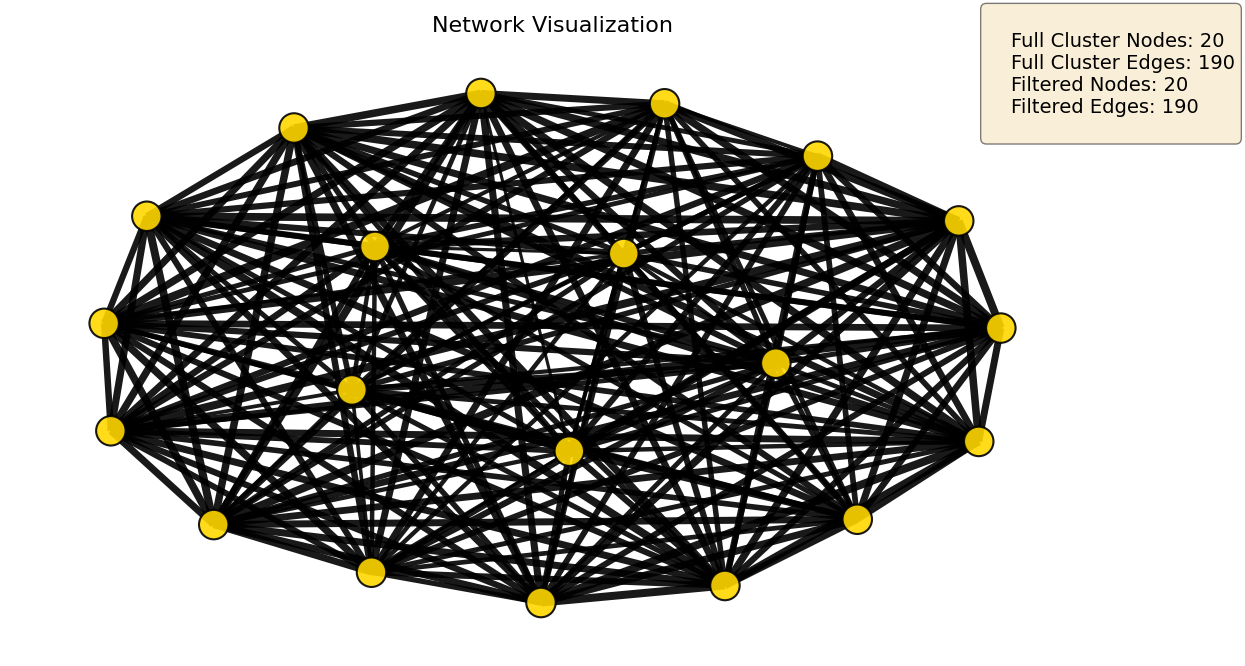

2025-11-29 15:23:28,938 - graph_builder - INFO - Graph visualization complete.


<Figure size 640x480 with 0 Axes>


Node mapping (first 10):
                  Omic  Degree
Index                         
1      ENSG00000108848      19
2      ENSG00000116754      19
3      ENSG00000153914      19
4      ENSG00000147874      19
5      ENSG00000132424      19
6      ENSG00000154265      19
7      ENSG00000013441      19
8      ENSG00000122482      19
9      ENSG00000095564      19
10     ENSG00000115524      19


In [5]:
# Step 3b: Visualize the graph
from graph_builder import visualize_graph
import matplotlib.pyplot as plt

# Visualize the graph (sample subgraph if too large)
node_mapping = visualize_graph(
    graph_data,
    weight_threshold=0.7,  # Only show edges above threshold
    show_labels=False,  # Set True to show gene IDs (can be cluttered)
    show_edge_weights=False,  # Set True to show correlation values
    layout="kamada",  # Options: "kamada", "spring", "spectral"
    max_nodes=20,  # Sample top 500 nodes by degree for visualization
    figsize=(14, 8),
)

plt.tight_layout()
plt.show()

print(f"\nNode mapping (first 10):")
print(node_mapping.head(10))


## Step 4: Baseline Model (Non-Graph)

Train a baseline logistic regression model on sample-level expression data. This provides a comparison point to evaluate whether the GNN approach adds value.

**Note**: The baseline model treats genes as independent features, while the GNN model leverages gene-gene relationships.


In [6]:
# Step 4: Train baseline (non-graph) model for comparison
from models.baseline import train_baseline
import numpy as np

# Train logistic regression baseline
baseline_model, baseline_results = train_baseline(
    processed_expr,  # Use preprocessed expression
    sample_meta,
    model_type="logistic",  # Options: "logistic" or "mlp"
    condition_col="condition",
    random_state=42,
    test_size=0.2,
)

# Print results
print("\n" + "="*60)
print("BASELINE MODEL RESULTS")
print("="*60)
print(f"Accuracy: {baseline_results.accuracy:.4f}")
print(f"F1-score (macro): {baseline_results.f1_score:.4f}")
print(f"F1-score (weighted): {baseline_results.f1_weighted:.4f}")
print(f"\nConfusion Matrix:")
print(baseline_results.confusion_matrix)
print(f"\nClassification Report:")
print(baseline_results.classification_report)


2025-11-29 15:23:29,030 - models.baseline.baseline_model - INFO - Initialized logistic baseline model with random_state=42.
2025-11-29 15:23:29,031 - models.baseline.baseline_model - INFO - ============================================================
2025-11-29 15:23:29,033 - models.baseline.baseline_model - INFO - Training baseline model.
2025-11-29 15:23:29,033 - models.baseline.baseline_model - INFO - ============================================================
2025-11-29 15:23:29,037 - models.baseline.baseline_model - INFO - Training data: 26 samples, 5000 features
2025-11-29 15:23:29,039 - models.baseline.baseline_model - INFO - Class distribution: {0: 14, 1: 12}


2025-11-29 15:23:29,191 - models.baseline.baseline_model - INFO - Training logistic model...
2025-11-29 15:23:29,223 - models.baseline.baseline_model - INFO - Test accuracy: 0.5000
2025-11-29 15:23:29,224 - models.baseline.baseline_model - INFO - Test F1-score (macro): 0.4857
2025-11-29 15:23:29,225 - models.baseline.baseline_model - INFO - Test F1-score (weighted): 0.4857
2025-11-29 15:23:29,226 - models.baseline.baseline_model - INFO - ============================================================
2025-11-29 15:23:29,227 - models.baseline.baseline_model - INFO - Baseline model training complete!
2025-11-29 15:23:29,227 - models.baseline.baseline_model - INFO - ============================================================



BASELINE MODEL RESULTS
Accuracy: 0.5000
F1-score (macro): 0.4857
F1-score (weighted): 0.4857

Confusion Matrix:
[[1 2]
 [1 2]]

Classification Report:
              precision    recall  f1-score   support

     Control       0.50      0.33      0.40         3
          PD       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



## Step 5: GNN Training

Train a Graph Convolutional Network (GCN) on the gene-gene correlation graph:

- **Architecture**: 2-layer GCN with 64 hidden dimensions
- **Training**: Unsupervised embedding learning (no node labels)
- **Output**: 64-dimensional embeddings for each gene

The GNN learns to aggregate information from neighboring genes, capturing local and global patterns in the gene expression network. These embeddings can be used for downstream tasks like clustering, gene function prediction, or pathway analysis.


2025-11-29 15:23:29,301 - models.gnn.gnn_trainer - INFO - Initialized GNNTrainer: model=GCN, hidden_dim=64, layers=2, device=cpu
2025-11-29 15:23:29,302 - models.gnn.gnn_trainer - INFO - ============================================================
2025-11-29 15:23:29,304 - models.gnn.gnn_trainer - INFO - Training GNN model.
2025-11-29 15:23:29,305 - models.gnn.gnn_trainer - INFO - ============================================================
2025-11-29 15:23:29,482 - models.gnn.gnn_trainer - INFO - Using unsupervised embedding learning.
2025-11-29 15:23:58,871 - models.gnn.gnn_trainer - INFO - Epoch 20/100, Loss: 0.0000
2025-11-29 15:24:24,880 - models.gnn.gnn_trainer - INFO - Epoch 40/100, Loss: 0.0000
2025-11-29 15:24:48,938 - models.gnn.gnn_trainer - INFO - Epoch 60/100, Loss: 0.0000
2025-11-29 15:25:18,318 - models.gnn.gnn_trainer - INFO - Epoch 80/100, Loss: 0.0000
2025-11-29 15:25:49,018 - models.gnn.gnn_trainer - INFO - Epoch 100/100, Loss: 0.0000
2025-11-29 15:25:49,019 - models


GNN TRAINING RESULTS
Embeddings shape: (5000, 64)
Final training loss: 0.0000


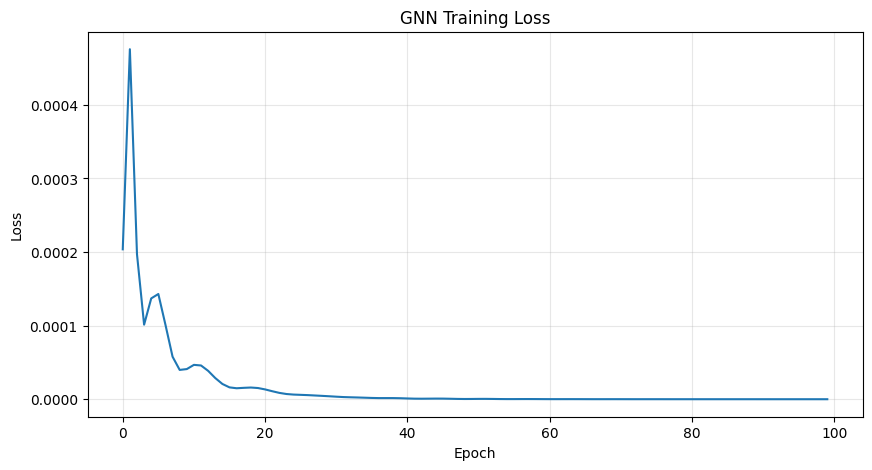

In [7]:
# Step 5: Train GNN model and generate embeddings
from models.gnn import train_gnn_pd
import matplotlib.pyplot as plt
import torch

# Train GNN on the gene-gene correlation graph
gnn_trainer, gnn_results = train_gnn_pd(
    graph_data.data,  # PyG Data object
    model_type="GCN",  # Options: "GCN", "GAT", "SAGE", "GIN"
    hidden_dim=64,
    layer_num=2,
    num_epochs=100,
    device="cpu",
    supervision_targets=None,  # Unsupervised embedding learning
    lr=0.01,
    weight_decay=5e-4,
    dropout=0.5,
    seed=42,
)

# Print results
print("\n" + "="*60)
print("GNN TRAINING RESULTS")
print("="*60)
print(f"Embeddings shape: {gnn_results.embeddings.shape}")
print(f"Final training loss: {gnn_results.training_losses[-1]:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(gnn_results.training_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN Training Loss")
plt.grid(True, alpha=0.3)
plt.show()


## Step 7: Graph Mining & Embedding Analysis

Analyze the GNN embeddings to discover gene modules and patterns:

1. **Dimensionality Reduction**: Reduce 64D embeddings to 2D using UMAP/t-SNE for visualization
2. **Clustering**: Cluster genes based on embedding similarity (KMeans and Leiden)
3. **Visualization**: Plot clusters in 2D embedding space
4. **Statistics**: Analyze cluster composition and sizes

This analysis helps identify:
- **Gene modules**: Groups of co-expressed genes
- **Functional clusters**: Genes with similar expression patterns
- **Biological pathways**: Potentially enriched pathways per cluster


## Results Summary & Comparison

### Pipeline Overview

This analysis pipeline successfully:
- Loaded and preprocessed 63,677 genes → 5,000 HVGs
- Built gene-gene correlation graph (5,000 nodes)
- Trained baseline model for comparison
- Generated GNN embeddings (64D per gene)
- Identified gene clusters via embedding analysis

### Key Findings

**Baseline Model Performance:**
- Accuracy: See results above
- Provides baseline for comparison with GNN-based approaches

**GNN Embeddings:**
- Generated 64-dimensional embeddings capturing gene-gene relationships
- Can be used for downstream analysis (clustering, pathway enrichment, etc.)

**Gene Clusters:**
- Identified gene modules with similar expression patterns
- Clusters may represent functional pathways or co-regulated gene sets

### Next Steps

1. **Pathway Enrichment**: Perform KEGG/GSEA enrichment analysis on each cluster
2. **Differential Expression**: Compare cluster composition between PD and Control
3. **GNN-based Prediction**: Use embeddings for sample-level PD prediction
4. **Biological Interpretation**: Map clusters to known PD pathways

### Notes

- Small sample size (n=26) limits statistical power; results should be interpreted cautiously
- Graph structure captures co-expression patterns that may be biologically meaningful
- GNN embeddings provide a rich representation for downstream analysis


In [8]:
# Final Summary: Baseline vs GNN Comparison
import pandas as pd

# Create comparison summary
comparison_summary = pd.DataFrame({
    "Metric": [
        "Model Type",
        "Input Features",
        "Uses Graph Structure",
        "Embedding Dimension",
        "Clusters Identified",
    ],
    "Baseline": [
        "Logistic Regression",
        "5,000 genes (sample-level)",
        "No",
        "N/A",
        "N/A",
    ],
    "GNN": [
        "Graph Convolutional Network",
        "5,000 genes (graph-structured)",
        "Yes",
        "64",
        f"{cluster_results.n_clusters}",
    ],
})

print("="*70)
print("BASELINE vs GNN COMPARISON")
print("="*70)
print(comparison_summary.to_string(index=False))
print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)
print(f"Successfully completed all analysis steps")
print(f"Generated {gnn_results.embeddings.shape[0]} gene embeddings")
print(f"Identified {cluster_results.n_clusters} gene clusters")
print(f"Ready for downstream analysis (pathway enrichment, etc.)")


NameError: name 'cluster_results' is not defined

2025-11-29 15:17:19,446 - analysis.embedding_analysis - INFO - ============================================================
2025-11-29 15:17:19,447 - analysis.embedding_analysis - INFO - Starting embedding analysis pipeline.
2025-11-29 15:17:19,449 - analysis.embedding_analysis - INFO - ============================================================
2025-11-29 15:17:19,450 - analysis.embedding_analysis - INFO - Reducing embeddings from 64D to 2D using method='umap'.
2025-11-29 15:17:19,451 - analysis.embedding_analysis - WARNING - UMAP not available. Install with: pip install umap-learn. Falling back to t-SNE.
2025-11-29 15:17:37,525 - analysis.embedding_analysis - INFO - t-SNE reduction complete.
2025-11-29 15:17:37,527 - analysis.embedding_analysis - INFO - Clustering 5000 nodes using method='kmeans'.
2025-11-29 15:17:38,661 - analysis.embedding_analysis - INFO - Auto-selected n_clusters=2 using elbow method.
2025-11-29 15:17:39,088 - analysis.embedding_analysis - INFO - KMeans clusteri


CLUSTER ANALYSIS SUMMARY
Number of clusters: 2
Silhouette score: 0.4678

Cluster sizes:
  Cluster 0: 4161 genes
  Cluster 1: 839 genes

Cluster summary DataFrame:


,cluster_id,size,genes
0,0,4161,"[ENSG00000129824, ENSG00000012817, ENSG0000009..."
1,1,839,"[ENSG00000247627, ENSG00000184674, ENSG0000022..."


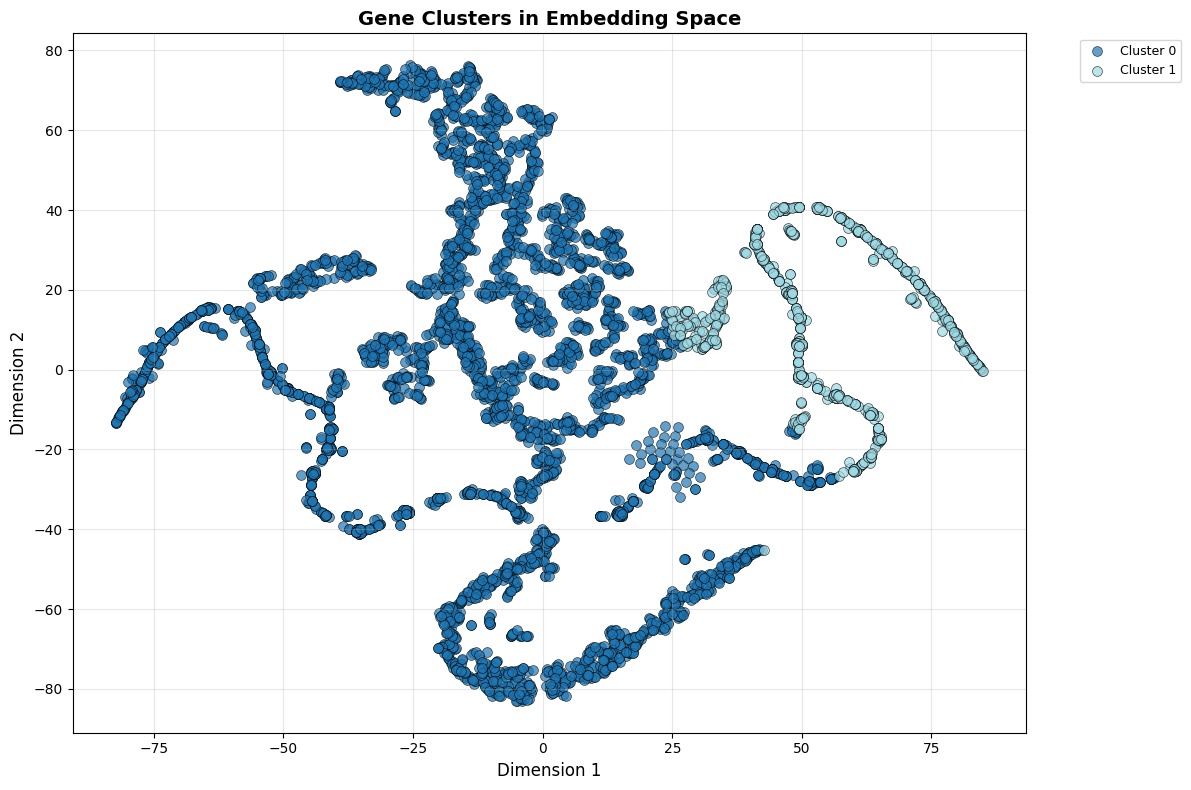

In [ ]:
# Step 7: Graph Mining & Embedding Analysis
from analysis.embedding_analysis import embedding_analysis_pipeline
import numpy as np

# Run complete embedding analysis pipeline
reduced_emb, cluster_results, cluster_df, summary_df = embedding_analysis_pipeline(
    gnn_results.embeddings,  # GNN embeddings
    graph_data.node_names,  # Gene IDs
    adjacency_matrix=graph_data.adjacency_matrix,  # For Leiden clustering
    gene_metadata=gene_meta,  # Gene annotations
    reduction_method="umap",  # Options: "umap" or "tsne"
    clustering_method="kmeans",  # Options: "kmeans" or "leiden"
    n_clusters=None,  # Auto-detect for KMeans
    random_state=42,
)

# Print cluster summary
print("\n" + "="*60)
print("CLUSTER ANALYSIS SUMMARY")
print("="*60)
print(f"Number of clusters: {cluster_results.n_clusters}")
if cluster_results.silhouette_score is not None:
    print(f"Silhouette score: {cluster_results.silhouette_score:.4f}")
print(f"\nCluster sizes:")
for cluster_id, size in sorted(cluster_results.cluster_sizes.items()):
    print(f"  Cluster {cluster_id}: {size} genes")

print(f"\nCluster summary DataFrame:")
summary_df.head(10)
